[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

[[20]]
[1] TRUE

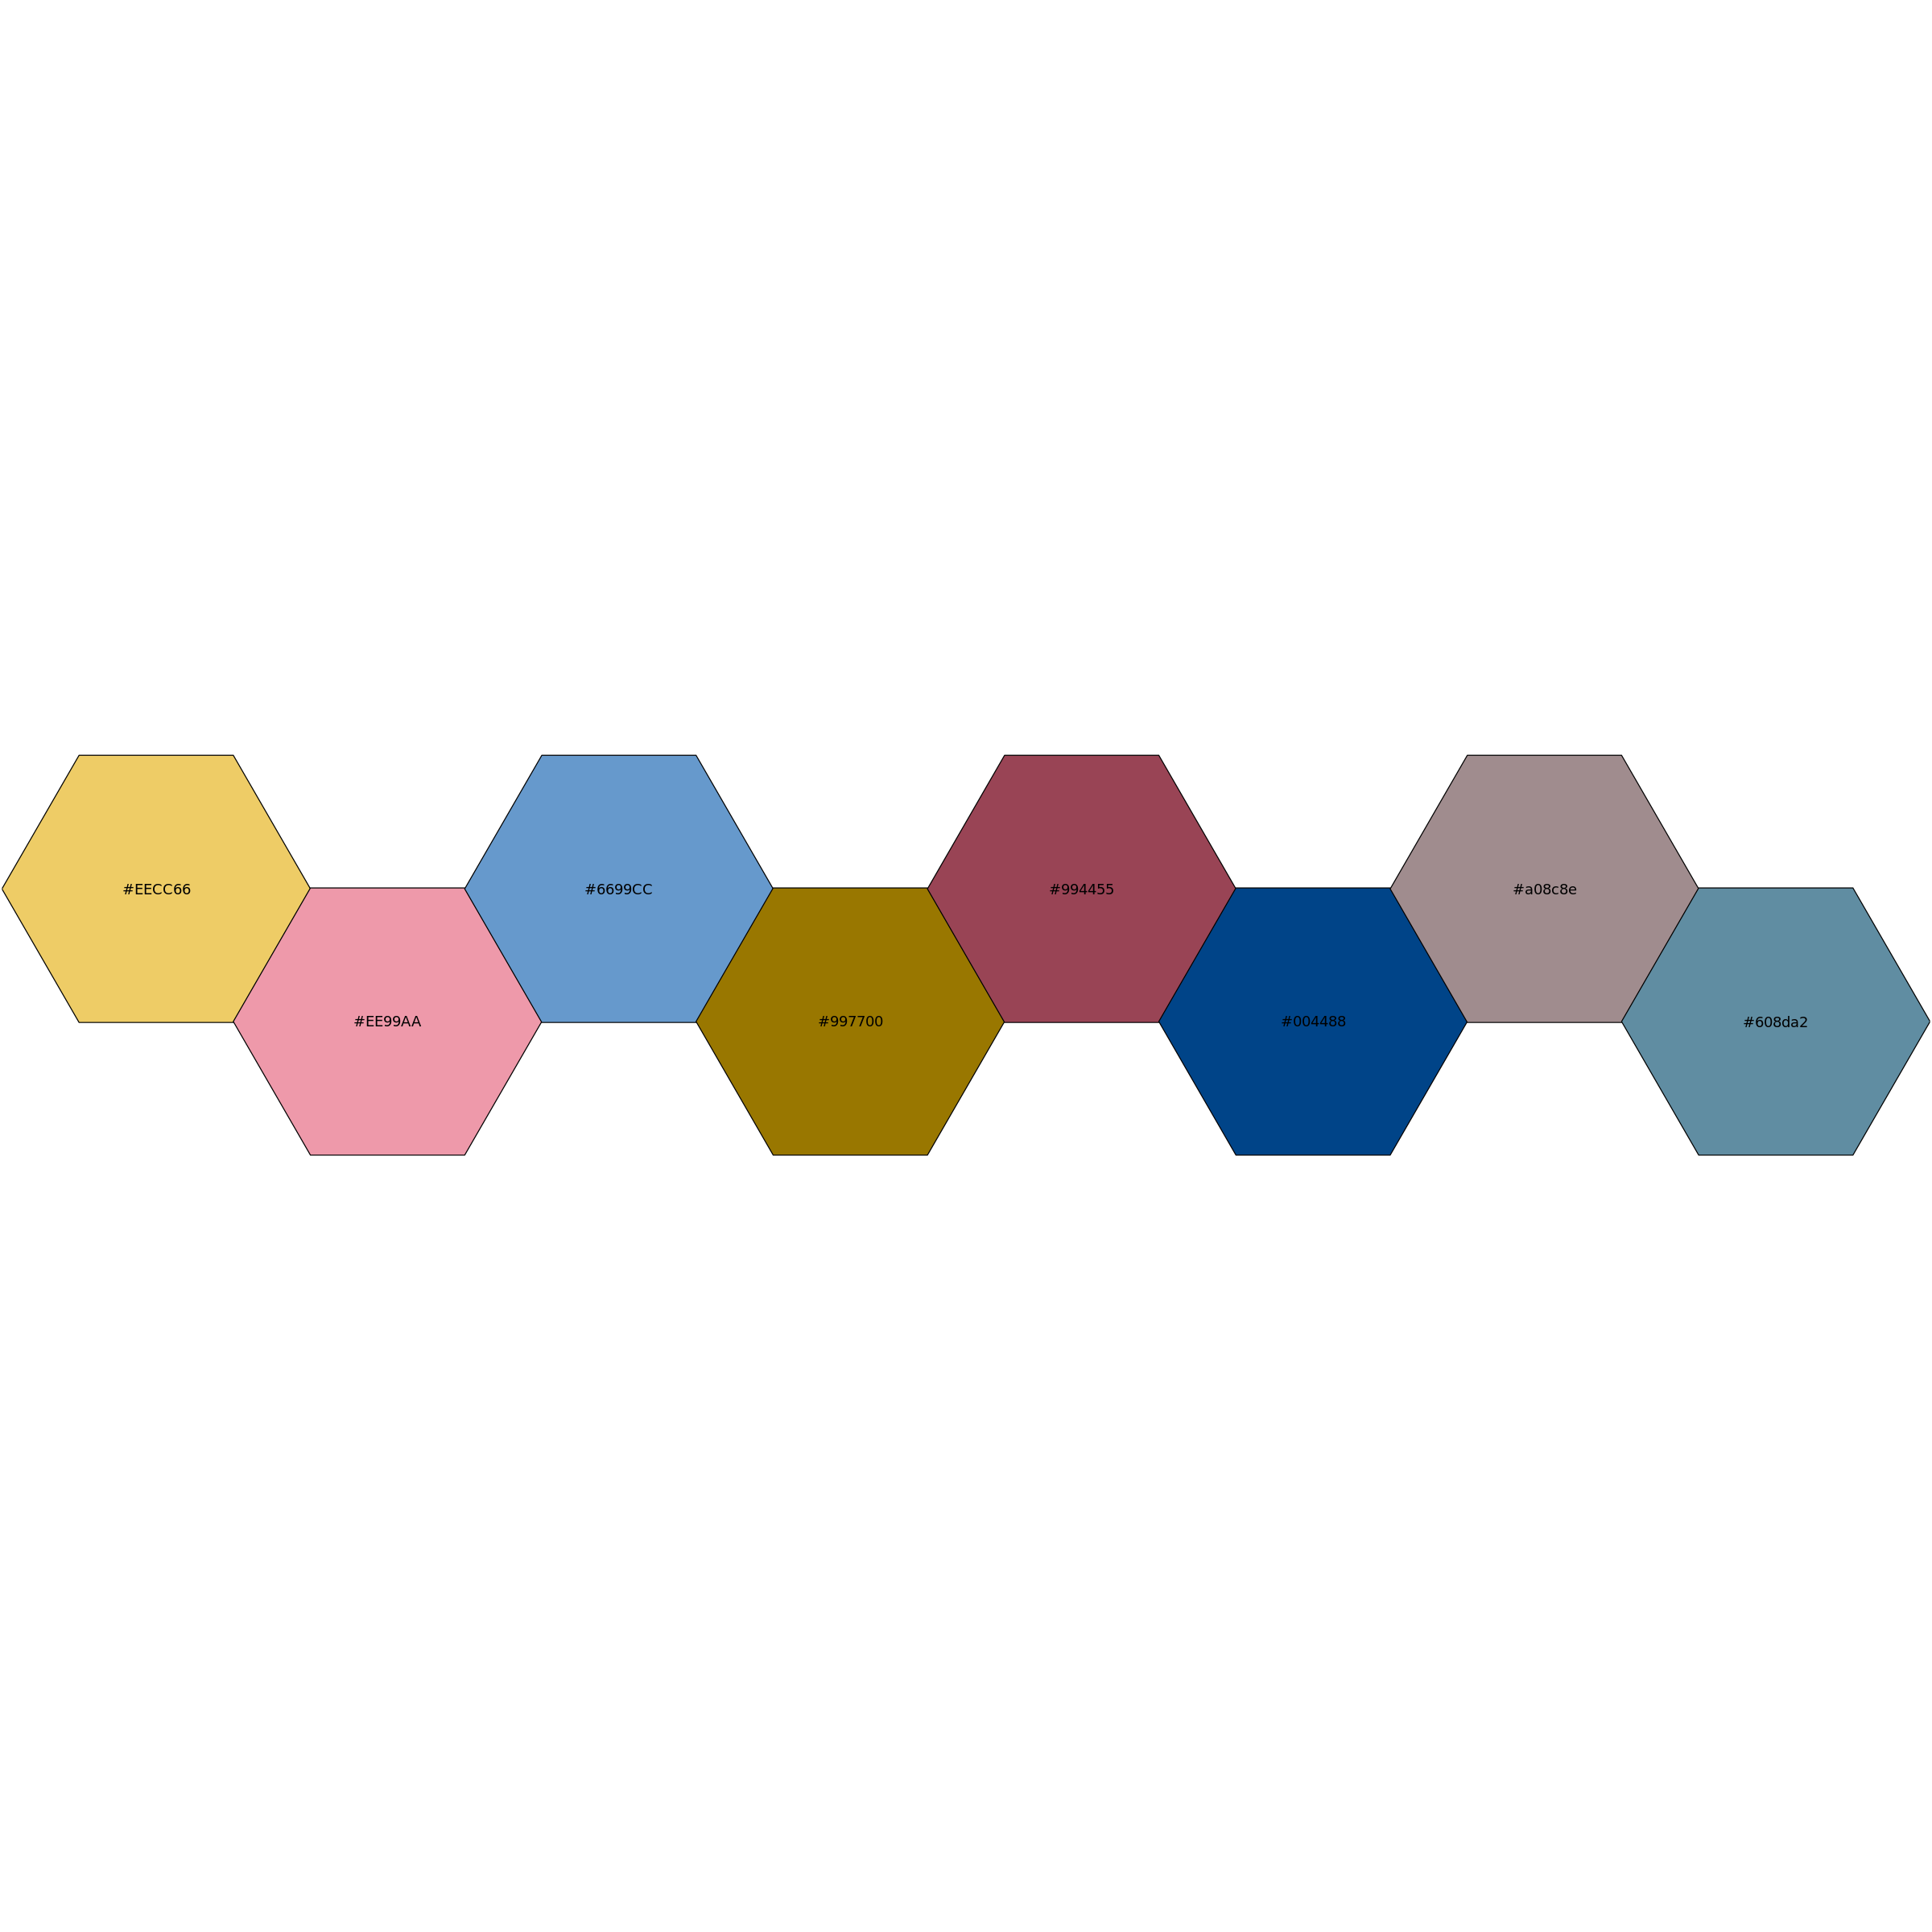

In [10]:
f_func <- "../functions.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_func, '--to=script', '--stdout'), stdout = TRUE)))
f_path <- "../dirs.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_path, '--to=script', '--stdout'), stdout = TRUE)))
f_cols <- "../cols.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_cols, '--to=script', '--stdout'), stdout = TRUE)))

In [11]:
Fungi_RPM <- readRDS(paste0(INT_SPL, "Fungi_RPM.Rdata"))
Asp_genus_RPM <- readRDS(paste0(INT_SPL, "Asp_genus_RPM.Rdata"))
Asp_fum_RPM <- readRDS(paste0(INT_SPL, "Asp_fum_RPM.Rdata"))

Fungi_count <- readRDS(paste0(INT_SPL, "Fungi_count.Rdata"))
Asp_genus_count <- readRDS(paste0(INT_SPL, "Asp_genus_count.Rdata"))
Asp_fum_count <- readRDS(paste0(INT_SPL, "Asp_fum_count.Rdata"))
total_read_count <- readRDS(paste0(INT_SPL, "total_read_count.Rdata"))

In [12]:
names(Fungi_count)
merge(Fungi_count[[wright_threshold]] %>% melt(varnames = c("db", "sample_id")), 
    total_read_count[[wright_threshold]] %>% melt(varnames = c("db", "sample_id")), by = c("db", "sample_id")) %>%
    mutate(value = (value.x/value.y)*10) %>% head()

[1] "conf0.0" "conf0.1" "conf0.2" "conf0.3" "conf0.4" "conf0.5" "conf0.6"
 [8] "conf0.7" "conf0.8" "conf0.9" "conf1.0"

,db,sample_id,value.x,value.y,value
,<fct>,<fct>,<int>,<int>,<dbl>
1,EPRSc2,A01Basp,1765,87047421,2.027630e-04
2,EPRSc2,A01BaspK,842,49813639,1.690300e-04
3,EPRSc2,A01Pasp,781,93337222,8.367509e-05
4,EPRSc2,A01PaspK,186,60618237,3.068384e-05
5,EPRSc2,A01Pctrl,10,114545908,8.730124e-07
6,EPRSc2,A01PctrlK,1,69412303,1.440667e-07


In [13]:
Fungal_RPM_df <- Fungi_RPM[[wright_threshold]] %>% 
    melt(varnames = c("db", "sample_id"), value.name = "value") %>%  
    mutate(name = "Fungi") %>% 
    filter(db %in% dbs_sel_min)
Asp_genus_RPM_df <- Asp_genus_RPM[[wright_threshold]] %>% 
    melt(varnames = c("db", "sample_id"), value.name = "value") %>%  
    mutate(name = "Aspergillus") %>% 
    filter(db %in% dbs_sel_min)

df_RPM_Asp <- rbind(Asp_genus_RPM_df) %>%
    mutate(origin = ifelse(grepl(sample_id, pattern = "^A") & grepl(sample_id, pattern = "asp"), yes = "IPA samples",
                    ifelse(grepl(sample_id, pattern = "^A") & grepl(sample_id, pattern = "ctrl"), yes = "Internal controls",
                    ifelse(grepl(sample_id, pattern = "^H"), yes = "External controls", 
                    ifelse(grepl(sample_id, pattern = "^N"), yes = "controls", no = NA)))))  %>% 

    mutate(sample_short = str_replace(sample_id, str_sub(sample_id, 1, 3), "")) %>% 
    mutate(sample = ifelse(grepl(sample_id, pattern = "[0-9]B[a-z]"), yes = "BAL", 
                  ifelse(grepl(sample_id, pattern = "[0-9]P[a-z]"), yes = "plasma", no = "control")))  %>% 
    mutate(type = ifelse(grepl(sample_id, pattern = "K$"), yes = "ds-cfDNA", 
                  ifelse(grepl(sample_id, pattern = "P$"), yes = "ds-wcDNA", no = "ss-cfDNA"))) %>% 
    mutate(sample_type = paste(sample, type))  %>% 
    mutate(origin = fct_relevel(origin, c("IPA samples","Internal controls","External controls", "controls")))  %>% 
    mutate(sample_type = fct_relevel(sample_type, c("plasma ds-cfDNA", "plasma ss-cfDNA", 
                                                    "BAL ds-cfDNA", "BAL ss-cfDNA", 
                                                    "BAL ds-wcDNA")))  %>% 
    mutate(type = fct_relevel(type, c("ss-cfDNA", "ds-cfDNA", "ds-wcDNA"))) %>% 
    filter(origin != "controls")  %>% 
    filter(origin != "Internal controls")  %>% 
    mutate(sample_sh = substr(sample_id, 1, 3))  %>% 
    mutate(sample_sh = ifelse(grepl(sample_id, pattern = "VAL"), paste0(sample_sh, "val"), sample_sh)) 

In [14]:
options(repr.plot.width=20, repr.plot.height=11)
fig_PREV_prep <- df_RPM_Asp %>% 
    filter(sample_id != "A05PaspVAL") %>% 
    filter(origin == "IPA samples") %>% 
    mutate(sample_short = str_sub(sample_id, 1, 3)) %>% 
    filter(sample_short %nin% c("A11", "A12", "A13", "A16")) %>% 
    filter(db %in% dbs_sel_min) %>%
    group_by(db, sample_type, type, name) %>%
    summarise(count_detect = length(which(value != 0)), 
              count_all = length(value), 
              fraction = count_detect/count_all*100, .groups = "keep") %>% 
    mutate(sample_type = fct_relevel(sample_type, c("plasma ds-cfDNA", "plasma ss-cfDNA", 
                                                    "BAL ds-cfDNA", "BAL ss-cfDNA", 
                                                    "BAL ds-wcDNA"))) %>% 
    filter(!grepl(sample_type, pattern = "wcDNA")) %>% 
    mutate(db = ifelse(db == "EPRSc2", yes = "cRE.21", no = as.character(db))) %>% 
    mutate(db = ifelse(db == "EPRSFv64MCAspDM", yes = "dREM.260", no = as.character(db))) %>% 
    ggplot(aes(x=fraction, y = sample_type, fill = type), alpha = 0.4) + 
    geom_bar(stat="identity") +
        facet_nested( ~ db, space = "free", scales = "free") + 
        scale_fill_manual(values = alpha(c("ss-cfDNA" = colors_mc[6], 
                                      "ds-cfDNA" = colors_mc[5], 
                                      "ds-wcDNA" = colors_mc[4]), 0.6)) + 
        theme_bw() +
        theme(strip.background=element_rect(fill="white", color = "white"), 
              strip.text.y.right = element_text(), 
              axis.title.y=element_blank(), legend.title=element_blank(), 
              axis.text.y=element_blank()) + 
        xlab("prevalence Aspergillus (G)") +
        scale_x_continuous(limits=c(0,100), breaks = seq(0,100,25)) +
        geom_text(aes(label=paste0(count_detect,"/",count_all)), x=0, stat='count', size=6, hjust = 0) +
        ggtitle("ss-cfDNA vs ds-cfDNA")

fig_PREV_specimen <- df_RPM_Asp %>%  
    filter(sample_id != "A05PaspVAL") %>% 
    mutate(sample_short = str_sub(sample_id, 1, 3)) %>% 
    filter(sample_short %nin% c("A11", "A12", "A13", "A16")) %>% 
    filter(db %in% dbs_sel_min) %>%
    group_by(db, sample_type, type, name, origin) %>%
    summarise(count_detect = length(which(value != 0)), 
              count_all = length(value), 
              fraction = count_detect/count_all*100, .groups = "keep") %>% 
    mutate(sample_type = fct_relevel(sample_type, c("plasma ds-cfDNA", "plasma ss-cfDNA", 
                                                    "BAL ds-cfDNA", "BAL ss-cfDNA", 
                                                    "BAL ds-wcDNA"))) %>% 
    filter(!grepl(sample_type, pattern = "ds-cfDNA")) %>% 
    mutate(db = ifelse(db == "EPRSc2", yes = "cRE.21", no = as.character(db))) %>% 
    mutate(db = ifelse(db == "EPRSFv64MCAspDM", yes = "dREM.260", no = as.character(db))) %>% 
    ggplot(aes(x=fraction, y = sample_type, fill = type)) + 
        geom_bar(stat="identity") +
        facet_grid(rows = vars(origin), cols = vars(db), space = "free", scales = "free") + 
        scale_fill_manual(values = alpha(c("ss-cfDNA" = colors_mc[6], 
                                      "ds-cfDNA" = colors_mc[5], 
                                      "ds-wcDNA" = colors_mc[4]), 0.6)) + 
        theme_bw() +
        theme(strip.background=element_rect(fill="white", color = "white"), 
              strip.text.y.right = element_text(), 
              axis.title.y=element_blank(), legend.title=element_blank(), 
              axis.text.y=element_blank()) + 
        xlab("prevalence Aspergillus (G)") +
        scale_x_continuous(limits=c(0,100), breaks = seq(0,100,25)) +
        geom_text(aes(label=paste0(count_detect,"/",count_all)), x=0, stat='count', size=6, hjust = 0) +
        ggtitle("wcDNA vs ss-cfDNA")

In [15]:
Fun_count_df <- Fungi_count[[wright_threshold]] %>% 
    melt(varnames = c("db", "sample_id"), value.name = "Fun_count_df") 
total_read_count_df <- total_read_count[[wright_threshold]] %>% 
    melt(varnames = c("db", "sample_id"), value.name = "total_read_count") 

fig_read_counts_Fun <- merge(x = Fun_count_df, y = total_read_count_df, by = c("db", "sample_id")) %>% 
    mutate(origin = ifelse(grepl(sample_id, pattern = "^A") & grepl(sample_id, pattern = "asp"), yes = "IPA samples",
                    ifelse(grepl(sample_id, pattern = "^A") & grepl(sample_id, pattern = "ctrl"), yes = "Internal controls",
                    ifelse(grepl(sample_id, pattern = "^H"), yes = "External controls", 
                    ifelse(grepl(sample_id, pattern = "^N"), yes = "controls", no = NA)))))  %>% 
    mutate(sample_short = str_replace(sample_id, str_sub(sample_id, 1, 3), "")) %>% 
    mutate(sample = ifelse(grepl(sample_id, pattern = "[0-9]B[a-z]"), yes = "BAL", 
                  ifelse(grepl(sample_id, pattern = "[0-9]P[a-z]"), yes = "plasma", no = "control")))  %>% 
    mutate(type = ifelse(grepl(sample_id, pattern = "K$"), yes = "ds-cfDNA", 
                  ifelse(grepl(sample_id, pattern = "P$"), yes = "ds-wcDNA", no = "ss-cfDNA"))) %>% 
    mutate(sample_type = paste(sample, type))  %>% 
    mutate(origin = fct_relevel(origin, c("IPA samples","Internal controls","External controls", "controls")))  %>% 
    mutate(sample_type = fct_relevel(sample_type, c("plasma ds-cfDNA", "plasma ss-cfDNA", 
                                                    "BAL ds-cfDNA", "BAL ss-cfDNA", 
                                                    "BAL ds-wcDNA")))  %>% 
    mutate(type = fct_relevel(type, c("ss-cfDNA", "ds-cfDNA", "ds-wcDNA"))) %>% 
    filter(origin != "controls")  %>% 
    filter(origin != "Internal controls")  %>% 
    mutate(sample_sh = substr(sample_id, 1, 3))  %>%  
    filter(sample_sh %nin% c("A11", "A12", "A13", "A16")) %>% 
    mutate(sample_sh = ifelse(grepl(sample_id, pattern = "VAL"), paste0(sample_sh, "val"), sample_sh)) %>% 
    filter(db %in% dbs_sel_min) %>% 
    group_by(db,sample) %>% 
    mutate(db = ifelse(db == "EPRSc2", yes = "cRE.21", no = as.character(db))) %>% 
    mutate(db = ifelse(db == "EPRSFv64MCAspDM", yes = "dREM.260", no = as.character(db))) %>%    
    filter(origin != "IPA samples") %>% 
    mutate(Fun_count_df = Fun_count_df/total_read_count*10^6) %>% 
    ggplot(aes(y = total_read_count, x = Fun_count_df, col = type)) + 
        geom_line(aes(group = sample_sh), color = "grey", linetype = "dashed") + 
        geom_point(aes(shape = origin), size = 5, alpha = 0.5) + 
        facet_grid(cols = vars(db), rows = vars(sample), space = "free") +
        xlim(0,30) + ylim(0,c(2*10^8.1)) +
        stat_cor(method = "pearson", alternative = 'greater', size = 6) + 
        theme_bw() +
        theme(strip.background=element_rect(fill="white", color = "white"), 
              strip.text.y.right = element_text(), 
              axis.text.x=element_text(),
              legend.title=element_blank()) +
        xlab("RPM fungi") + ylab ("total read count") + 
        scale_color_manual(values = c("ss-cfDNA" = colors_mc[6], 
                                      "ds-cfDNA" = colors_mc[5], 
                                      "ds-wcDNA" = colors_mc[4])) 

In [16]:
my_comp_prep <- list(c("plasma ds-cfDNA", "plasma ss-cfDNA"),
                c("BAL ds-cfDNA", "BAL ss-cfDNA"))
my_comp_specimen <- list(c("BAL ss-cfDNA", "plasma ss-cfDNA"), 
                 c("BAL ds-wcDNA", "plasma ss-cfDNA"),                  
                c("BAL ds-wcDNA", "BAL ss-cfDNA"))

stat.test <- compare_means(as.data.frame(df_RPM_Asp),   
                           formula = value~sample_type, group.by = c("db","name", "origin"), 
                           method = "wilcox.test",
                           p.adjust.method = "bonferroni") %>% 
            mutate(db = ifelse(db == "EPRSc2", yes = "cRE.21", no = as.character(db))) %>% 
            mutate(db = ifelse(db == "EPRSFv64MCAspDM", yes = "dREM.260", no = as.character(db))) 
stat.test$plot_pvalue <- round(stat.test$p, digits = 3)

stat.test_prep <- stat.test %>%
    filter(origin == "IPA samples") %>% 
    filter(group1 %in% my_comp_prep[[1]] & group2 %in% my_comp_prep[[1]] | 
           group1 %in% my_comp_prep[[2]] & group2 %in% my_comp_prep[[2]] ) %>% 
    filter(db %in% c("cRE.21", "dREM.260")) 

stat.test_specimen <- stat.test %>%
    filter(group1 %in% my_comp_specimen[[1]] & group2 %in% my_comp_specimen[[1]] | 
           group1 %in% my_comp_specimen[[2]] & group2 %in% my_comp_specimen[[2]] | 
           group1 %in% my_comp_specimen[[3]] & group2 %in% my_comp_specimen[[3]] ) %>% 
    filter(db %in% c("cRE.21", "dREM.260")) 

fig_RPM_prep <- df_RPM_Asp %>% 
    filter(sample_id != "A05PaspVAL") %>% 
    mutate(sample_short = str_sub(sample_id, 1, 3)) %>% 
    filter(sample_short %nin% c("A11", "A12", "A13", "A16")) %>% 
    filter(db %in% dbs_sel_min) %>%
    filter(origin == "IPA samples") %>% 
    filter(!grepl(sample_type, pattern = "wcDNA")) %>% 
    mutate(db = ifelse(db == "EPRSc2", yes = "cRE.21", no = as.character(db))) %>% 
    mutate(db = ifelse(db == "EPRSFv64MCAspDM", yes = "dREM.260", no = as.character(db))) %>%      
    ggplot(., aes(x=sample_type, y=value, color = type)) + 
        geom_line(aes(x = sample_type, y = value, group = sample_sh), color = "grey", linetype = "dashed") + 
        geom_boxplot(aes(x = sample_type, y=value, fill = type), lwd=0.8, fill = "white") + 
        geom_point(aes(x = sample_type, y=value, col = type), size = 2) + 
        stat_pvalue_manual(stat.test_prep, y.position = rep(c(90,90),2), coord.flip = TRUE,
                           label = "p.signif",remove.bracket = FALSE) +
        facet_grid(rows = vars(origin), cols = vars(db), space = "free", scales = "free") + 
        scale_color_manual(values = c("ss-cfDNA" = colors_mc[6], 
                                      "ds-cfDNA" = colors_mc[5], 
                                      "ds-wcDNA" = colors_mc[4])) + 
        theme_bw() +
        theme(strip.background=element_rect(fill="white", color = "white"), 
              strip.text.y.right = element_text(), 
              legend.title=element_blank()) + 
        ylab("RPM Aspergillus (G)") + xlab("") + 
        scale_y_continuous(limits=c(-10, 100), breaks = seq(0,100,25)) +
        geom_text(aes(label=paste0("n=", after_stat(count))), y=-15, stat='count', size=6, hjust = 0) +
        coord_flip() + ggtitle("ss-cfDNA vs ds-cfDNA library") + guides(color = "none")

fig_RPM_specimen <- df_RPM_Asp %>% 
    filter(sample_id != "A05PaspVAL") %>% 
    mutate(sample_short = str_sub(sample_id, 1, 3)) %>% 
    filter(sample_short %nin% c("A11", "A12", "A13", "A16")) %>% 
    filter(db %in% dbs_sel_min) %>%
    filter(!grepl(sample_type, pattern = "ds-cfDNA")) %>% 
    mutate(db = ifelse(db == "EPRSc2", yes = "cRE.21", no = as.character(db))) %>% 
    mutate(db = ifelse(db == "EPRSFv64MCAspDM", yes = "dREM.260", no = as.character(db))) %>%      
    ggplot(., aes(x=sample_type, y=value, color = type)) + 
        geom_line(aes(x = sample_type, y = value, group = sample_sh), color = "grey", linetype = "dashed") + 
        geom_boxplot(aes(x = sample_type, y=value, fill = type), lwd=0.8, fill = "white") + 
        geom_point(aes(x = sample_type, y=value, col = type), size = 2) + 
        stat_pvalue_manual(stat.test_specimen, y.position = rep(c(80,90,100),4), coord.flip = TRUE,
                           label = "p.signif",remove.bracket = FALSE) +
        facet_grid(rows = vars(origin), cols = vars(db), space = "free", scales = "free") + 
        scale_color_manual(values = c("ss-cfDNA" = colors_mc[6], 
                                      "ds-cfDNA" = colors_mc[5], 
                                      "ds-wcDNA" = colors_mc[4])) + 
        theme_bw() +
        theme(strip.background=element_rect(fill="white", color = "white"), 
              strip.text.y.right = element_text(), 
              legend.title=element_blank()) + 
        ylab("RPM Aspergillus (G)") + xlab("") + 
        scale_y_continuous(limits=c(-10, 100), breaks = seq(0,100,25)) +
        geom_text(aes(label=paste0("n=", after_stat(count))), y=-15, stat='count', size=6, hjust = 0) +
        coord_flip() + ggtitle("wcDNA vs ss-cfDNA sample") + guides(color = "none")

In [17]:
df_RPM_Asp %>% 
    filter(sample_id != "A05PaspVAL") %>% 
    filter(db %in% dbs_sel_min) %>%
    filter(!grepl(sample_type, pattern = "ds-cfDNA")) %>% 
    mutate(db = ifelse(db == "EPRSc2", yes = "cRE.21", no = as.character(db))) %>% 
    mutate(db = ifelse(db == "EPRSFv64MCAspDM", yes = "dREM.260", no = as.character(db))) %>% 
    filter(origin == "IPA samples") %>% 
    filter(type == "ss-cfDNA") %>% 
    group_by(db, sample_type) %>% 
    summarise(mean = mean(value) , .groups = "keep")

db,sample_type,mean
<chr>,<fct>,<dbl>
cRE.21,plasma ss-cfDNA,1.783401
cRE.21,BAL ss-cfDNA,6.930276
dREM.260,plasma ss-cfDNA,1.887494
dREM.260,BAL ss-cfDNA,7.255792


`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


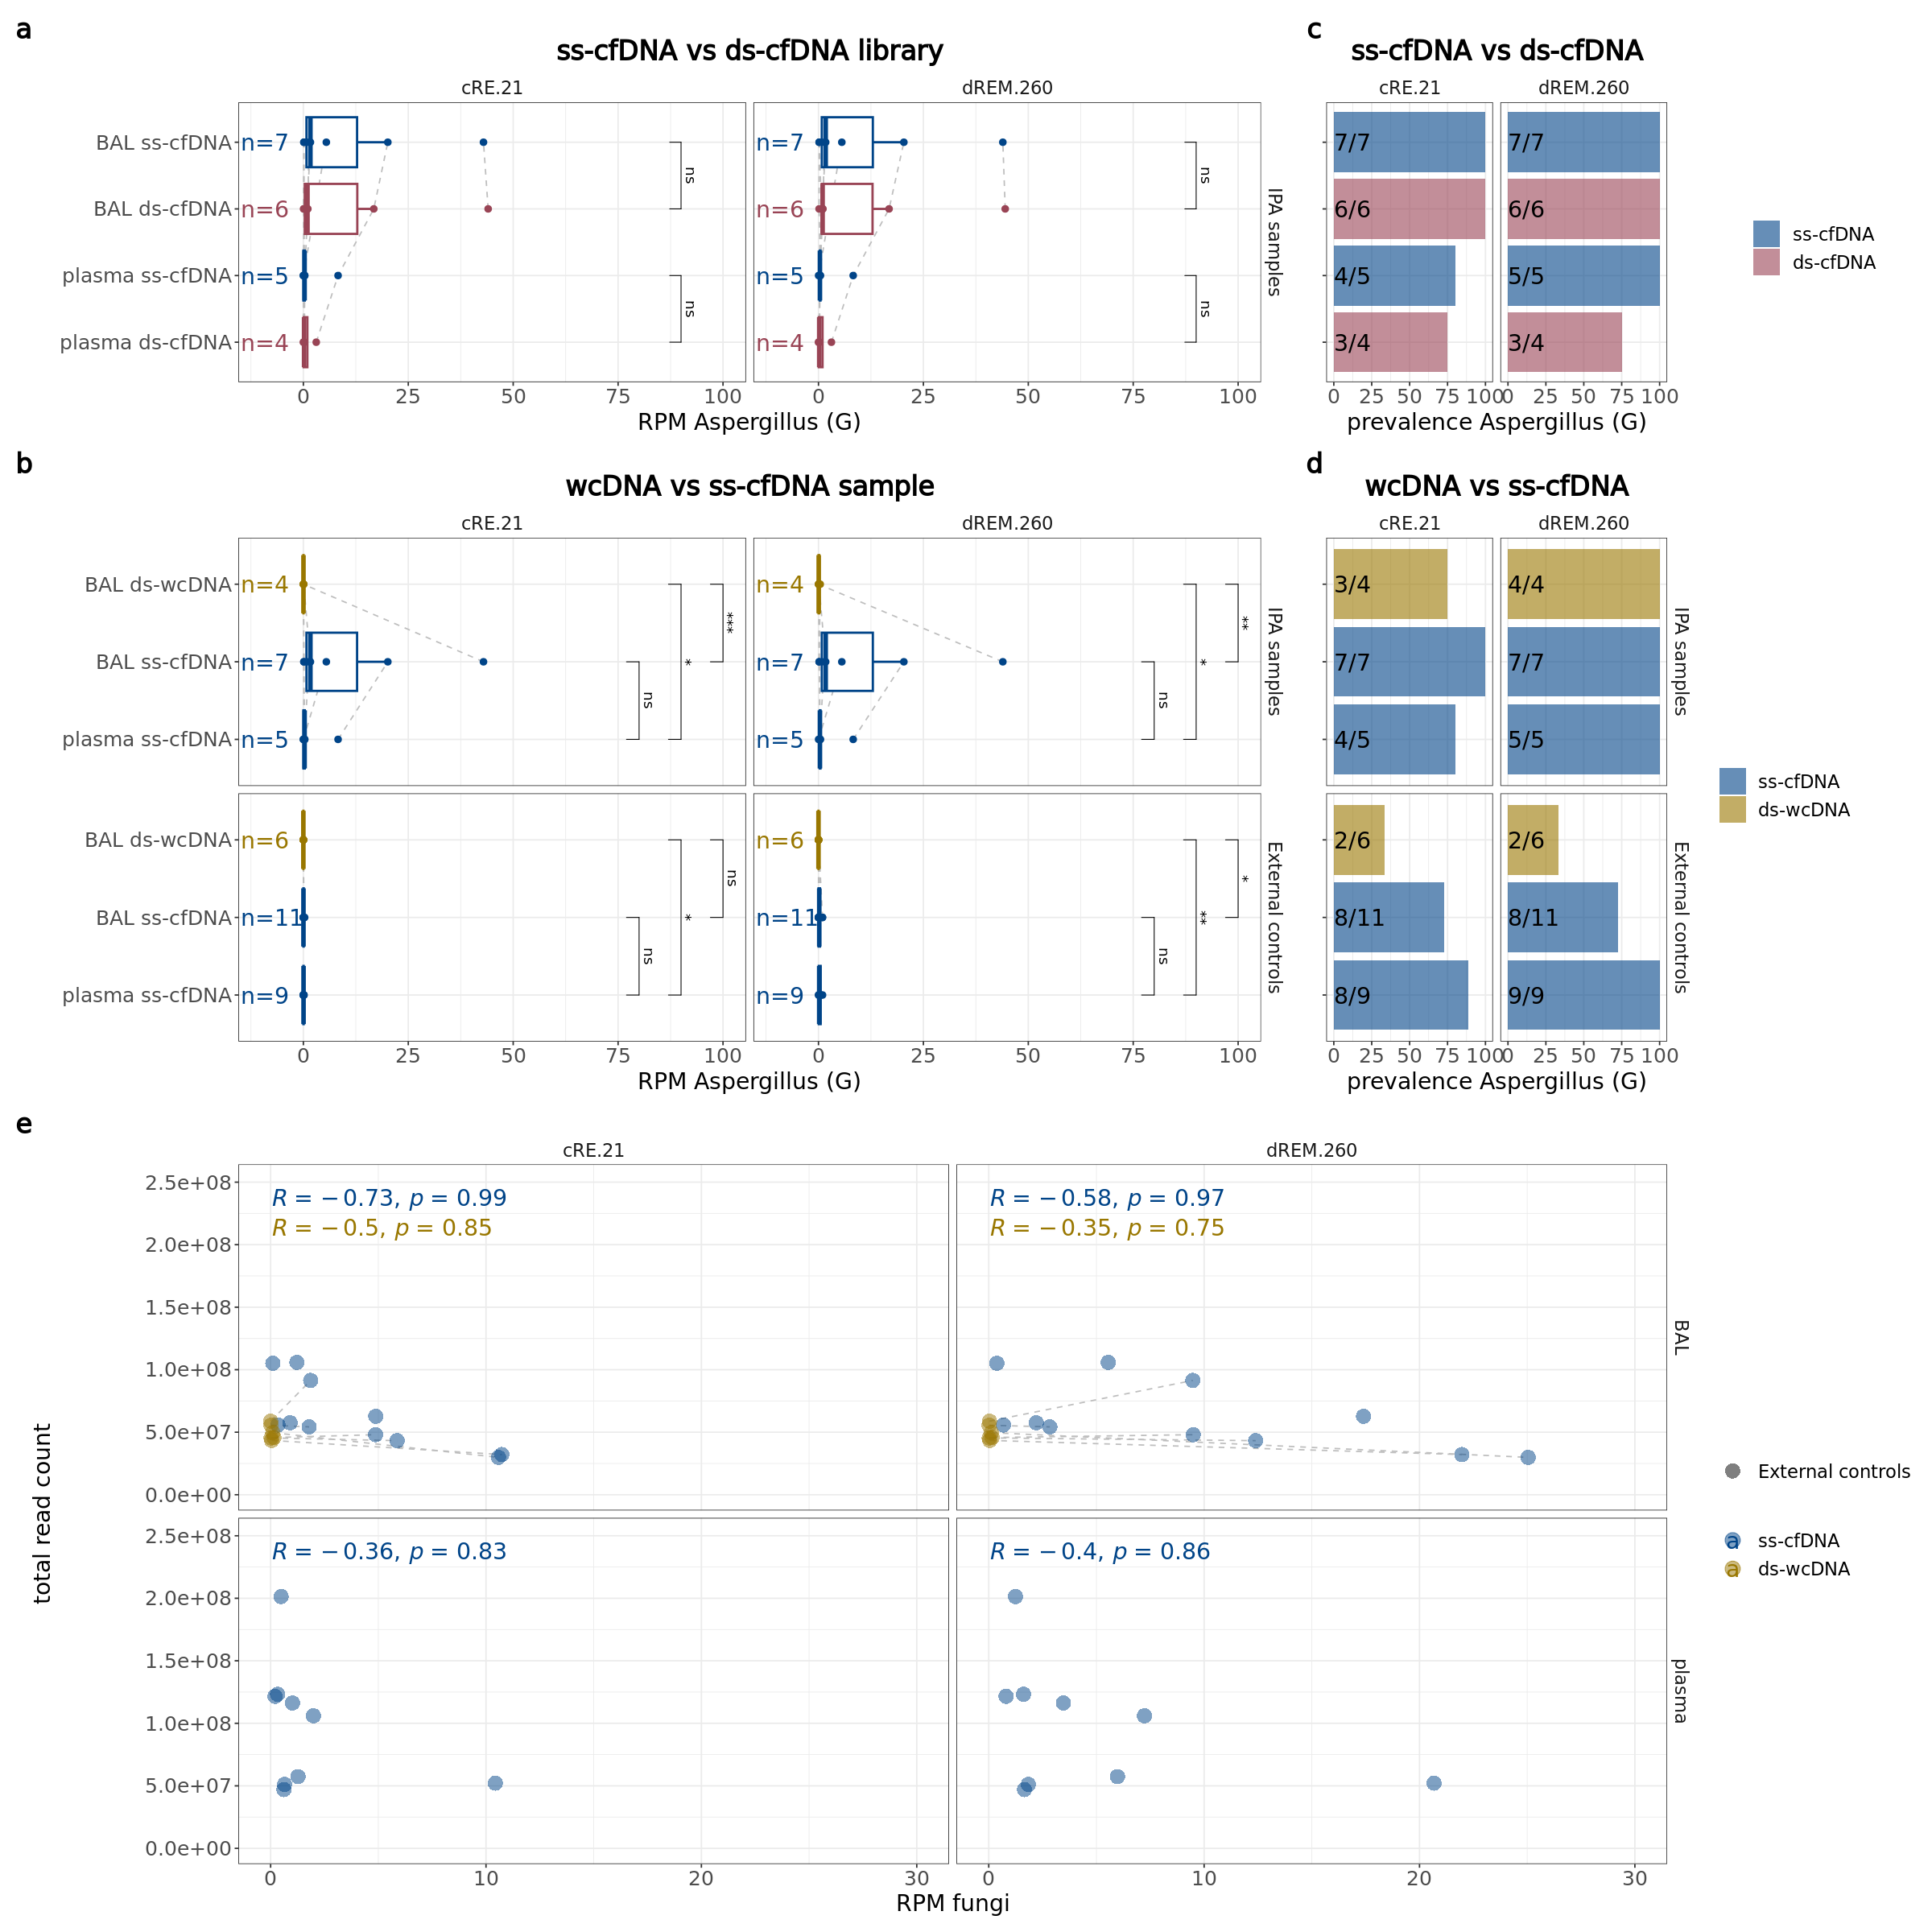

In [18]:
options(repr.plot.width=20, repr.plot.height=20)
layout <- "
    AC
    BD
    EE
"
SuplFig7 <- 
    (fig_RPM_prep + labs(tag = 'a')) + 
    (fig_RPM_specimen + labs(tag = 'b')) + 
    (fig_PREV_prep + labs(tag = 'c')) + 
    (fig_PREV_specimen + labs(tag = 'd'))+  
    (fig_read_counts_Fun + labs(tag = 'e')) + 
        plot_layout(design = layout, widths = c(3,1), heights = c(1,1.8,2.5)) &
        guides(size = 30) & 
        theme(legend.position='right', legend.justification='center', legend.direction = 'vertical',
        axis.text = element_text(size = 15), 
        legend.key.size = unit(0.75, 'cm'), legend.key.height = unit(0.75, 'cm'), legend.key.width = unit(0.75, 'cm'), 
        text = element_text(size = 17), 
        plot.title = element_text(size = 20, hjust = 0.5, face = "bold"), 
        plot.subtitle = element_text(size = 17, hjust = 0.5), 
        plot.tag = element_text(face = 'bold', size = 20))

SuplFig7

ggsave("../../output/suppl_figures/SuplFig7_R.png", 
       SuplFig7, width = 20, height = 20)
ggsave("../../output/suppl_figures/SuplFig7_R.pdf", 
       SuplFig7, width = 20, height = 20)